# **Text Classification and Text Summarization of BBC news**

In this project, we examine a dataset that includes BBC news articles across five categories: business, sport, tech, entertainment, and politics. Our analysis begins with data visualization, focusing on removing unnecessary columns to simplify the data handling. We then explore the dataset’s structure, remove any duplicates, and analyze the distribution of articles across the various categories. We also delve into the word counts and the lengths of articles within each category to gain a thorough understanding of the dataset.

The next phase involves text pre-processing, where we expand contractions, strip digits, clear extra white spaces, and convert all text to lowercase. Following these steps, the text is tokenized, normalized, and vectorized, making it ready for analysis through computational methods.

Regarding text classification, we employ five different techniques for text representation: the count vectorizer, the tfidf vectorizer, word2vec with Cbow, word2vec with skip gram and word2vec using a pre-trained model. For each textual representation we divide the dataset into a training set and a test set. The training data are used to train several models, including SVD, Random Forest, Decision Tree, Naive Bayes, and Logistic Regression, after performing hyperparameter optimization for each model using k-fold cross-validation with grid search.

#**Initialization**

In [ ]:
from urllib.request import install_opener
from google.colab import drive
import pandas as pd
from shutil import copyfile

#Graph
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Text pre-processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

#Workd Cloud
from wordcloud import WordCloud

#Text classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import numpy as np
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Select the working directory

In [ ]:
directory = "/content/gdrive/MyDrive/Text Mining/"

In [ ]:
drive.mount('/content/gdrive')
copyfile(directory + 'Dataset/bbc-news-data.csv', 'bbc.csv')

Mounted at /content/gdrive


'bbc.csv'

If you haven't downloaded the pre-trained model for word2cevtor yet and wish to use it, you will need to uncomment these lines to run them. This will trigger the download and save the model to the specified directory

In [ ]:
#wv = api.load('word2vec-google-news-300')
#wv.save(directory + 'vectors_ggnews300')

In [ ]:
ds = pd.read_csv("bbc.csv", sep="\t")

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
ds.content.duplicated().sum()

133

In [ ]:
ds.drop_duplicates(subset = "content" ,inplace=True)

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2092 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2092 non-null   object
 1   filename  2092 non-null   object
 2   title     2092 non-null   object
 3   content   2092 non-null   object
dtypes: object(4)
memory usage: 81.7+ KB


In [ ]:
def preprocess_text_nltk(text, language= "english"):
    # Normalization (lowercase)
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Rimozione delle stop words e caratteri non alfanumerici
    stop_words = set(stopwords.words(language))
    custom_stop_words = {"said", "may", "many", "made", "say", "take", "think", "use","would", "'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo'}
    stop_words.update(custom_stop_words)
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    return filtered_tokens

In [ ]:
ds['processed_text'] = ds['content'].apply(preprocess_text_nltk)
print(ds.processed_text.head())

0    [quarterly, profit, u, medium, giant, timewarn...
1    [dollar, hit, highest, level, euro, almost, th...
2    [owner, embattled, russian, oil, giant, yukos,...
3    [british, airway, blamed, high, fuel, price, 4...
4    [share, uk, drink, food, firm, allied, domecq,...
Name: processed_text, dtype: object


#**EDA**

In [ ]:
ds["category"].value_counts()

,count
category,
business,500
sport,494
politics,395
entertainment,366
tech,337


In [ ]:
# Converti `category.value_counts()` in un DataFrame e resetti l'indice
ds_pie = ds['category'].value_counts().reset_index()
ds_pie.columns = ['category', 'count']  # Rinomina le colonne per chiarezza

# Creazione del grafico a torta
fig = px.pie(
    ds_pie,
    values='count',  # Numero di occorrenze
    names='category',  # Nomi delle categorie
    color_discrete_sequence=px.colors.sequential.Darkmint,
    title='Count and frequency of news categories in the DataFrame',
    labels={'count': 'Count', 'category': 'Category'}
)

fig.show()

Text(0.5, 1.0, 'Distribution of news over the categories')

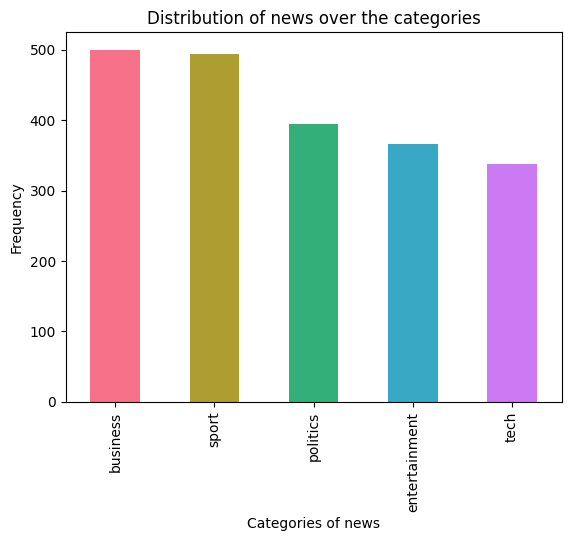

In [ ]:
ds['category'].value_counts().plot(kind='bar', color=sns.color_palette("husl", 5))
plt.xlabel('Categories of news')
plt.ylabel('Frequency')
plt.title('Distribution of news over the categories')

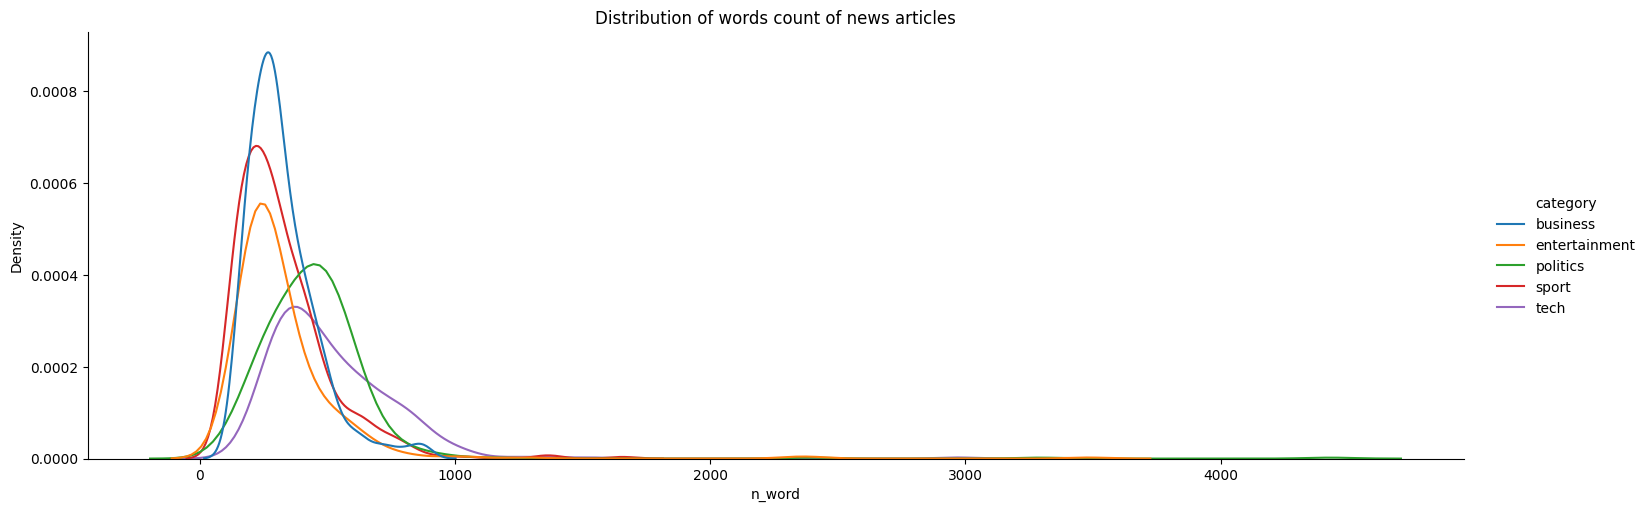

In [ ]:
ds["n_word"] = ds["content"].str.split().str.len()
sns.displot(ds, x="n_word", hue="category", kind="kde",height=5,aspect =3 ).set(title='Distribution of words count of news articles')

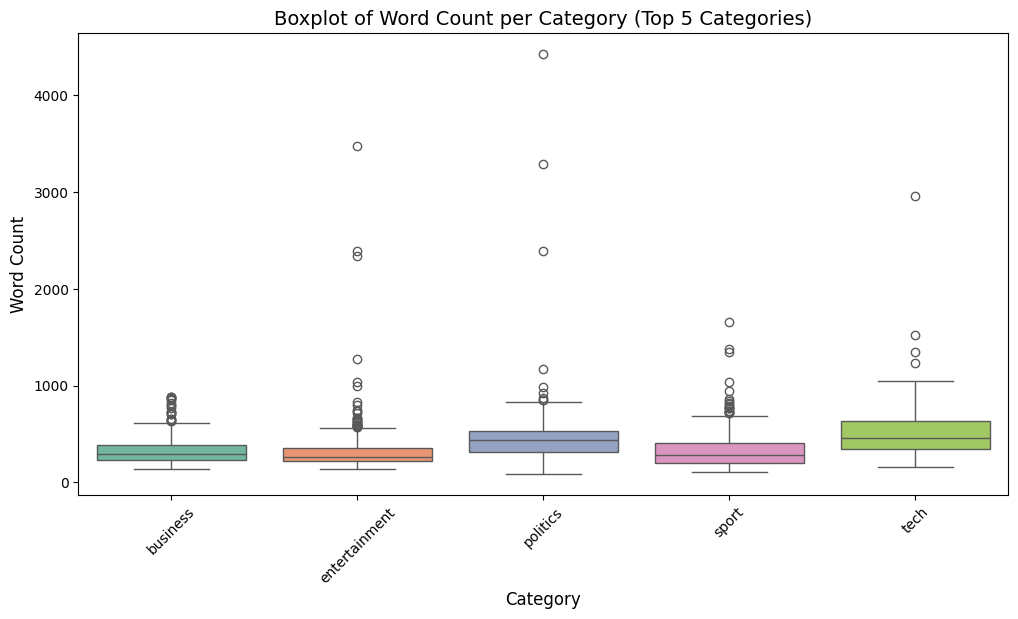

In [ ]:
# Creazione del boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=ds, x='category', y='n_word', palette='Set2', hue = ds['category']
)

# Aggiunta del titolo e delle etichette
plt.title('Boxplot of Word Count per Category (Top 5 Categories)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)  # Ruota i nomi delle categorie per una migliore leggibilità
plt.show()

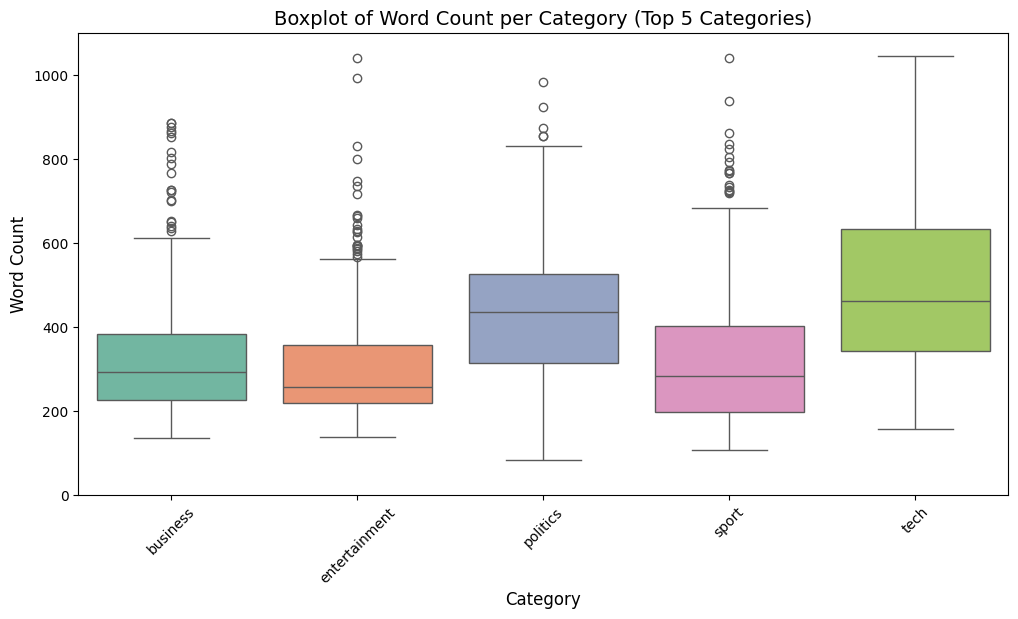

In [ ]:
# Creazione del boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=ds, x='category', y='n_word', palette='Set2', hue = ds['category']
)

# Aggiunta del titolo e delle etichette
plt.title('Boxplot of Word Count per Category (Top 5 Categories)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)  # Ruota i nomi delle categorie per una migliore leggibilità
plt.ylim(bottom=0, top=1100)
plt.show()

In [ ]:
# Scaricare i dati necessari
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("english"))
custom_stop_words = {"said", "may", "many", "made", "say", "take", "think", "use"}
stop_words.update(custom_stop_words)

In [ ]:
def preprocess_text_nltk(text, stopwords):
    # Normalization (lowercase)
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Rimozione delle stop words e caratteri non alfanumerici
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return lemmatized_tokens

In [ ]:
ds['processed_text'] = ds['content'].apply(lambda x: preprocess_text_nltk(x, stop_words))
print(ds.processed_text.head())

0    [quarterly, profit, u, medium, giant, timewarn...
1    [dollar, hit, highest, level, euro, almost, th...
2    [owner, embattled, russian, oil, giant, yukos,...
3    [british, airway, blamed, high, fuel, price, 4...
4    [share, uk, drink, food, firm, allied, domecq,...
Name: processed_text, dtype: object


In [ ]:
tech = ' '.join([' '.join(tokens) for tokens in ds.loc[ds.category == "tech", "processed_text"].dropna()])
business = ' '.join([' '.join(tokens) for tokens in ds.loc[ds.category == "business", "processed_text"].dropna()])
sport = ' '.join([' '.join(tokens) for tokens in ds.loc[ds.category == "sport", "processed_text"].dropna()])
entertainment = ' '.join([' '.join(tokens) for tokens in ds.loc[ds.category == "entertainment", "processed_text"].dropna()])
politics = ' '.join([' '.join(tokens) for tokens in ds.loc[ds.category == "politics", "processed_text"].dropna()])
all = ' '.join([' '.join(tokens) for tokens in ds.processed_text])

In [ ]:
def wordcloud_multiple(texts, titles, stop_words=None):
    """
    Genera una griglia di Word Cloud per più testi.

    Args:
        texts (list of str): Lista di stringhe di testo per cui generare le Word Cloud.
        titles (list of str): Lista di titoli corrispondenti per ciascun testo.
        stop_words (set): Set di stop words da escludere dalle Word Cloud (default: None).

    Returns:
        None: Mostra una finestra con tutte le Word Cloud.
    """
    if len(texts) != len(titles):
        raise ValueError("Il numero di testi deve corrispondere al numero di titoli.")

    # Configurazione della griglia
    num_texts = len(texts)
    cols = 2  # Numero di colonne nella griglia
    rows = -(-num_texts // cols)  # Calcolo del numero di righe (arrotondamento per eccesso)

    # Creazione della figura
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    axes = axes.flatten()  # Appiattisce l'array di assi (utile se ci sono meno assi del previsto)

    # Generazione delle Word Cloud
    for i, (text, title) in enumerate(zip(texts, titles)):
        wordcloud = WordCloud(
            width=1600,
            height=1000,
            background_color="black",
            stopwords=stop_words,
            min_font_size=10
        ).generate(text)

        # Disegna la Word Cloud
        axes[i].imshow(wordcloud)
        axes[i].set_title(f"Word Cloud for {title} Articles\n", fontsize=16)
        axes[i].axis("off")

    # Rimuove gli assi inutilizzati se ci sono meno testi delle celle della griglia
    for j in range(len(texts), len(axes)):
        fig.delaxes(axes[j])

    # Mostra la griglia
    plt.tight_layout()
    plt.show()

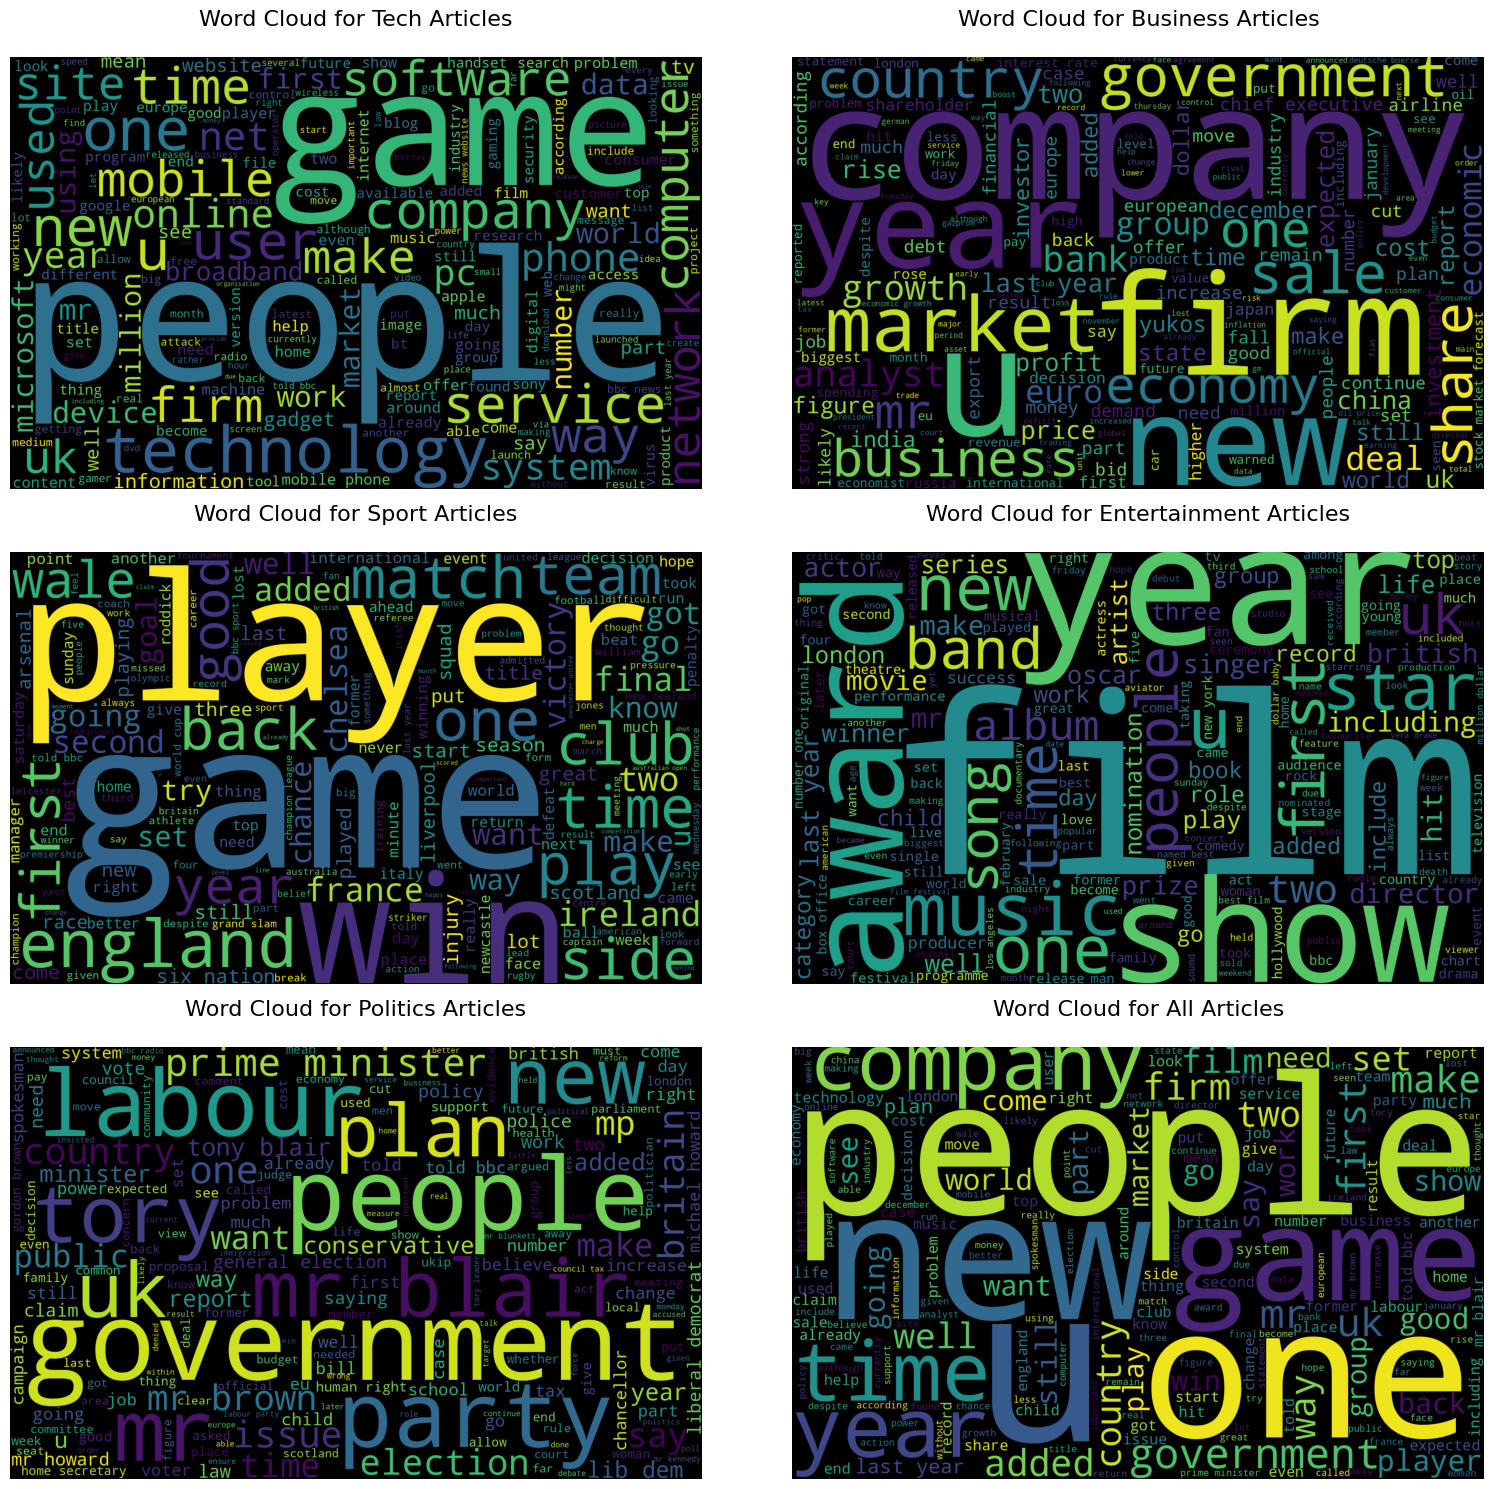

In [ ]:
texts = [tech, business, sport, entertainment, politics, all ]

titles = ["Tech", "Business", "Sport", "Entertainment", "Politics", "All"]

# Set di stop words (puoi usare NLTK o un tuo set personalizzato)
stop_words = None

# Genera le Word Cloud
wordcloud_multiple(texts, titles, stop_words=stop_words)

In [ ]:
def wordcloud(text, title):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "black",
        stopwords = stop_words,
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (16, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Articles\n", fontsize = 20)
    plt.axis("off")
    plt.show()

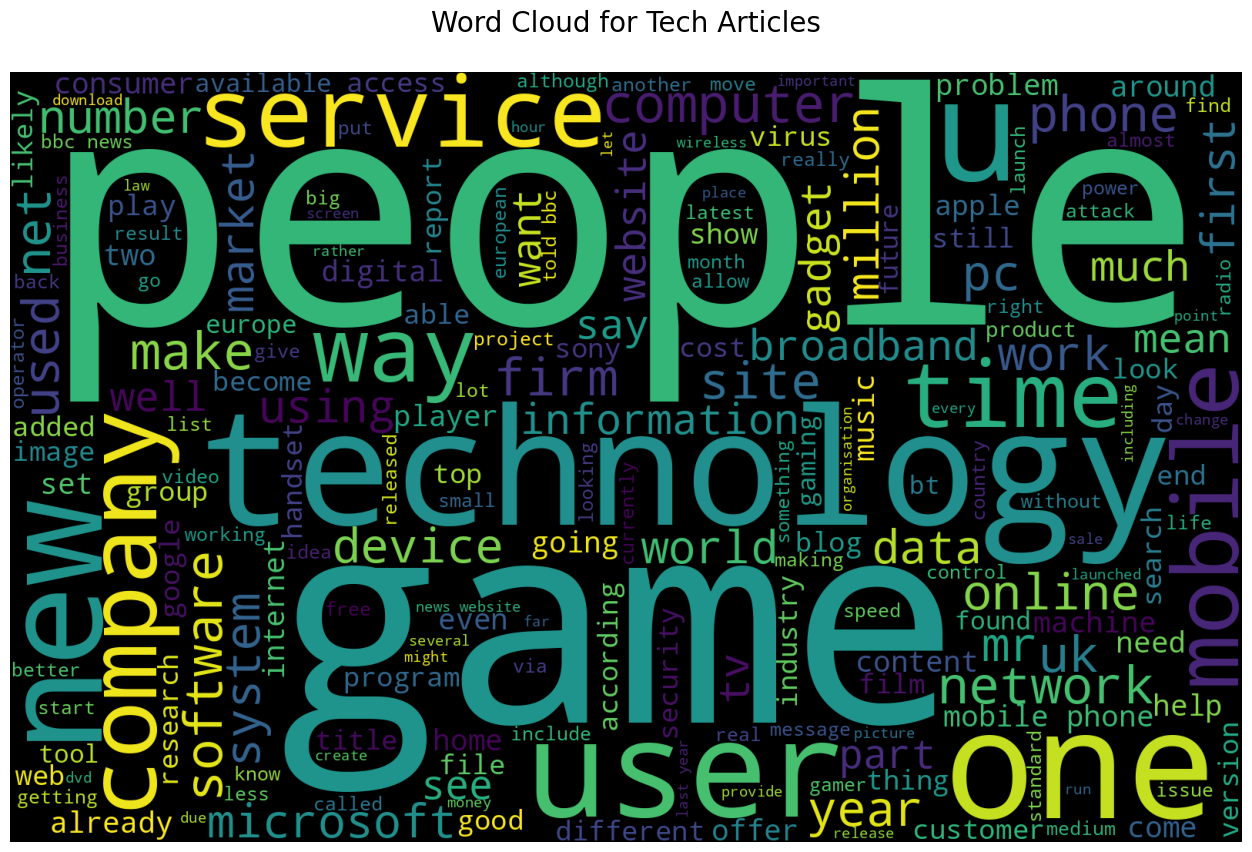

In [ ]:
wordcloud(tech, "Tech")

#**Text classification**

In [ ]:
X, Y = ds['content'], ds['category']
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=2001,stratify=Y)

##**Bag of word**

In [ ]:
stop_words = set(stopwords.words("english"))
custom_stop_words = {"said", "may", "many", "made", "say", "take", "think", "use","would", "'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo'}
stop_words.update(custom_stop_words)

In [ ]:
vectorizer_train = CountVectorizer(stop_words=list(stop_words))
X_train_vectorized = vectorizer_train.fit_transform(X_train)
x_test_vectorized = vectorizer_train.transform(X_test)

In [ ]:
vectorizer = CountVectorizer(stop_words=list(stop_words))
X_vectorized = vectorizer.fit_transform(X)

###SVM hyperparameter optimization

In [ ]:
# Define the SVC classifier
classifier_svc = SVC()

# Define the kernel functions to compare
parameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform grid search and cross-validation
grid_search_svc = GridSearchCV(classifier_svc, parameters, cv=5)
grid_search_svc.fit(X_train_vectorized, y_train)

#Best model
accuracy_cv_svc = grid_search_svc.best_score_

#Assegno il kernel selezionato
classifier_svc.kernel = grid_search_svc.best_params_['kernel']

#Performance
best_kernel = grid_search_svc.best_params_['kernel']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_svc = grid_search_svc.score(x_test_vectorized,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("SVC - Best Kernel:", best_kernel)
print("SVC - Cross-validated Accuracy:", accuracy_cv_svc)
print("SVC - Test accuracy:", accuracy_svc)
result_cv_svc = pd.DataFrame(grid_search_svc.cv_results_)
print(result_cv_svc.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

SVC - Best Kernel: linear
SVC - Cross-validated Accuracy: 0.9672144560287999
SVC - Test accuracy: 0.9665605095541401
                  params  mean_test_score  rank_test_score  mean_fit_time
0   {'kernel': 'linear'}         0.967214                1       1.901433
1      {'kernel': 'rbf'}         0.949448                3       3.935540
2     {'kernel': 'poly'}         0.403701                4       4.047260
3  {'kernel': 'sigmoid'}         0.965171                2       1.752479


### Decision Tree Hyperparameter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_dt = DecisionTreeClassifier()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"]}

# Perform grid search and cross-validation
grid_search_dt = GridSearchCV(classifier_dt, param_grid, cv=5)
grid_search_dt.fit(X_train_vectorized, y_train)

#Assegno i parametre selezionati
classifier_dt.max_depth = grid_search_dt.best_params_['max_depth']
classifier_dt.min_samples_leaf = grid_search_dt.best_params_['min_samples_leaf']
classifier_dt.criterion = grid_search_dt.best_params_['criterion']

# Evaluate the best model
best_model_dt = grid_search_dt.best_estimator_
accuracy_cv_dt = grid_search_dt.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_dt = grid_search_dt.score(x_test_vectorized,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Decision tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision tree - Cross-validated Accuracy:", accuracy_cv_dt)
print("Decision tree - Test accuracy:", accuracy_dt)
#result_cv_dt = pd.DataFrame(grid_search_dt.cv_results_)
#print(result_cv_dt.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Decision tree - Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5}
Decision tree - Cross-validated Accuracy: 0.774615456543083
Decision tree - Test accuracy: 0.767515923566879


### Random Forest hyperparameter optimization

In [ ]:
# Define the Random forest classifier
classifier_rf = RandomForestClassifier()

# Define the hyperparameter grid for the Random forest classifier
param_grid = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"], "n_estimators": [10,20,50,100,150]}

# Perform grid search and cross-validation
grid_search_rf = GridSearchCV(classifier_rf, param_grid, cv=5)
grid_search_rf.fit(X_train_vectorized, y_train)

#Assegno gli iperparametri selezionati
classifier_rf.max_depth = grid_search_rf.best_params_['max_depth']
classifier_rf.min_samples_leaf = grid_search_rf.best_params_['min_samples_leaf']
classifier_rf.criterion = grid_search_rf.best_params_['criterion']
classifier_rf.n_estimators = grid_search_rf.best_params_['n_estimators']

# Evaluate the best model
best_model_rf = grid_search_rf.best_estimator_
accuracy_cv_rf = grid_search_rf.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_rf = grid_search_rf.score(x_test_vectorized,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Random forest - Best Parameters:", grid_search_rf.best_params_)
print("Random forest - Cross-validated Accuracy:", accuracy_cv_rf)
print("Random forest - Test accuracy:", accuracy_rf)
#result_cv_rf = pd.DataFrame(grid_search_rf.cv_results_)
#print(result_cv_rf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Random forest - Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
Random forest - Cross-validated Accuracy: 0.9549207536584225
Random forest - Test accuracy: 0.9442675159235668


### Multinomial Naive Bayes hyperparamter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_nb = MultinomialNB()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid = {'alpha': [2.0, 3, 1.5]}

# Perform grid search and cross-validation
grid_search_nb = GridSearchCV(classifier_nb, param_grid, cv=5)
grid_search_nb.fit(X_train_vectorized, y_train)

# Evaluate the best model
best_model_nb = grid_search_nb.best_estimator_
accuracy_cv_nb = grid_search_nb.best_score_

#Assegno gli iperparametri selezionati
classifier_nb.alpha = grid_search_nb.best_params_['alpha']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_nb = grid_search_nb.score(x_test_vectorized,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Naive Bayes - Best Parameters:", grid_search_nb.best_params_)
print("Naive Bayes - Cross-validated Accuracy:", accuracy_cv_nb)
print("Naive Bayes - Test accuracy:", accuracy_nb)
#result_cv_nb = pd.DataFrame(grid_search_nb.cv_results_)
#print(result_cv_nb.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Naive Bayes - Best Parameters: {'alpha': 3}
Naive Bayes - Cross-validated Accuracy: 0.9672191313291879
Naive Bayes - Test accuracy: 0.9697452229299363


### Logistic regression hyperparameter optimization

In [ ]:
# Define the Logistic Regression classifier
classifier_lr = LogisticRegression()

# Define the kernel functions to compare
combinations = {1 : [None, "newton-cg"], 2 : ["elasticnet", "saga", 0.5], 3 : ["l1", "saga"], 4 : ["l2", "lbfgs"]}

# Perform grid search and cross-validation
accuracy_cv_lr = 0
best_parameter = None

for combination in combinations:
    classifier_lr.penalty = combinations[combination][0]
    classifier_lr.solver = combinations[combination][1]
    if classifier_lr.penalty == "elasticnet":
        classifier_lr.l1_ratio = combinations[combination][2]
    else:
        classifier_lr.l1_ratio = None
    scores = cross_val_score(classifier_lr, X_train_vectorized, y_train, cv=5)
    accuracy = scores.mean()

    if accuracy > accuracy_cv_lr:
        accuracy_cv_lr = accuracy
        best_parameter = combinations[combination]

#Assegno gli iperparametri selezionati
classifier_lr.penalty = best_parameter[0]
classifier_lr.solver = best_parameter[1]
if classifier_lr.penalty == "elasticnet":
    classifier_lr.l1_ratio = best_parameter[2]

#Training the model with best hyper-parameter on the entire trainset
classifier_lr.fit(X_train_vectorized, y_train)

#Accuracy calculated on the test set
accuracy_lr = classifier_lr.score(x_test_vectorized,y_test)

print("Logistic Regression - Best parameters:", best_parameter)
print("Logistic Regression - Cross-validated Accuracy:", accuracy_cv_lr)
print("Logistic Regression - Test accuracy:", accuracy_lr)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Logistic Regression - Best parameters: ['l2', 'lbfgs']
Logistic Regression - Cross-validated Accuracy: 0.9644840806021786
Logistic Regression - Test accuracy: 0.9713375796178344


###Performance evaluation

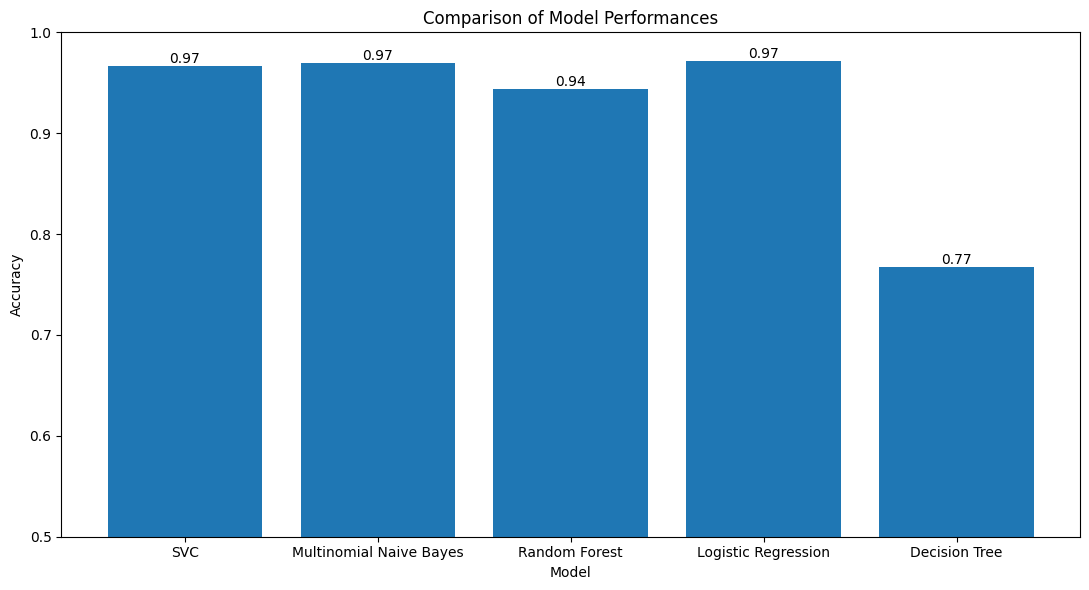

In [ ]:
# Define the models and their corresponding accuracies
models = ['SVC', 'Multinomial Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_svc, accuracy_nb, accuracy_rf, accuracy_lr, accuracy_dt]

# Plot the accuracies
plt.figure(figsize=(11, 6))
plt.bar(models, accuracies, width = 0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performances')
plt.ylim([0.5, 1])  # Set the y-axis limit from 0 to 1
# Aggiungere i valori sopra ogni barra
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()

## **Tf-idf**

In [ ]:
tfidf_train = TfidfVectorizer(stop_words=list(stop_words))
X_train_tfidf = tfidf_train.fit_transform(X_train)
x_test_tfidf = tfidf_train.transform(X_test)

### SVM hyperparameter optimization

In [ ]:
# Define the SVC classifier
classifier_svc_tfidf = SVC()

# Define the kernel functions to compare
parameters_svc_tfidf = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform grid search and cross-validation
grid_search_svc_tfidf = GridSearchCV(classifier_svc_tfidf, parameters_svc_tfidf, cv=5)
grid_search_svc_tfidf.fit(X_train_tfidf, y_train)

#Best model
classifier_svc_tfidf.kernel = grid_search_svc_tfidf.best_params_['kernel']
accuracy_cv_svc_tfidf = grid_search_svc_tfidf.best_score_

#Assegno il kernel selezionato
classifier_svc_tfidf.kernel = grid_search_svc_tfidf.best_params_['kernel']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_svc_tfidf = grid_search_svc_tfidf.score(x_test_tfidf,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("SVC - Best Kernel:", classifier_svc_tfidf.kernel)
print("SVC - Cross-validated Accuracy:", accuracy_cv_svc_tfidf)
print("SVC - Test accuracy:", accuracy_svc_tfidf)
result_cv_svc_tfidf = pd.DataFrame(grid_search_svc_tfidf.cv_results_)
print(result_cv_svc_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

SVC - Best Kernel: sigmoid
SVC - Cross-validated Accuracy: 0.9733648136892794
SVC - Test accuracy: 0.9761146496815286
                  params  mean_test_score  rank_test_score  mean_fit_time
0   {'kernel': 'linear'}         0.972682                2       3.533783
1      {'kernel': 'rbf'}         0.968591                3       4.127920
2     {'kernel': 'poly'}         0.604528                4       4.089692
3  {'kernel': 'sigmoid'}         0.973365                1       3.039385


### Decision Tree Hyperparameter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_dt_tfidf = DecisionTreeClassifier()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid_dt_tfidf = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"]}

# Perform grid search and cross-validation
grid_search_dt_tfidf = GridSearchCV(classifier_dt_tfidf, param_grid_dt_tfidf, cv=5)
grid_search_dt_tfidf.fit(X_train_tfidf, y_train)

#Assegno i parametre selezionati
classifier_dt_tfidf.max_depth = grid_search_dt_tfidf.best_params_['max_depth']
classifier_dt_tfidf.min_samples_leaf = grid_search_dt_tfidf.best_params_['min_samples_leaf']
classifier_dt_tfidf.criterion = grid_search_dt_tfidf.best_params_['criterion']

# Evaluate the best model
best_model_dt_tfidf = grid_search_dt_tfidf.best_estimator_
accuracy_cv_dt_tfidf = grid_search_dt_tfidf.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_dt_tfidf = grid_search_dt_tfidf.score(x_test_tfidf,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Decision tree - Best Parameters:", grid_search_dt_tfidf.best_params_)
print("Decision tree - Cross-validated Accuracy:", accuracy_cv_dt_tfidf)
print("Decision tree - Test accuracy:", accuracy_dt_tfidf)
#result_cv_dt_tfidf = pd.DataFrame(grid_search_dt_tfidf.cv_results_)
#print(result_cv_dt_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Decision tree - Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}
Decision tree - Cross-validated Accuracy: 0.7629809715274207
Decision tree - Test accuracy: 0.7754777070063694


### Random Forest hyperparameter optimization

In [ ]:
# Define the Random forest classifier
classifier_rf_tfidf = RandomForestClassifier()

# Define the hyperparameter grid for the Random forest classifier
param_grid_rf_tfidf = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"], "n_estimators": [10,20,50,100,150]}

# Perform grid search and cross-validation
grid_search_rf_tfidf = GridSearchCV(classifier_rf_tfidf, param_grid_rf_tfidf, cv=5)
grid_search_rf_tfidf.fit(X_train_tfidf, y_train)

#Assegno gli iperparametri selezionati
classifier_rf_tfidf.max_depth = grid_search_rf_tfidf.best_params_['max_depth']
classifier_rf_tfidf.min_samples_leaf = grid_search_rf_tfidf.best_params_['min_samples_leaf']
classifier_rf_tfidf.criterion = grid_search_rf_tfidf.best_params_['criterion']
classifier_rf_tfidf.n_estimators = grid_search_rf_tfidf.best_params_['n_estimators']

# Evaluate the best model
accuracy_cv_rf_tfidf = grid_search_rf_tfidf.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_rf_tfidf = grid_search_rf_tfidf.score(x_test_tfidf,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Random forest - Best Parameters:", grid_search_rf_tfidf.best_params_)
print("Random forest - Cross-validated Accuracy:", accuracy_cv_rf_tfidf)
print("Random forest - Test accuracy:", accuracy_rf_tfidf)
#result_cv_rf_tfidf = pd.DataFrame(grid_search_rf_tfidf.cv_results_)
#print(result_cv_rf_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Random forest - Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 150}
Random forest - Cross-validated Accuracy: 0.9542358221515732
Random forest - Test accuracy: 0.9522292993630573


### Multinomial Naive Bayes hyperparamter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_nb_tfidf = MultinomialNB()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid_nb_tfidf = {'alpha': [2.0, 3, 1.5]}

# Perform grid search and cross-validation
grid_search_nb_tfidf = GridSearchCV(classifier_nb_tfidf, param_grid_nb_tfidf, cv=5)
grid_search_nb_tfidf.fit(X_train_tfidf, y_train)

# Evaluate the best model
accuracy_cv_nb_tfidf = grid_search_nb_tfidf.best_score_

#Assegno gli iperparametri selezionati
classifier_nb_tfidf.alpha = grid_search_nb_tfidf.best_params_['alpha']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_nb_tfidf = grid_search_nb_tfidf.score(x_test_tfidf,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Naive Bayes - Best Parameters:", grid_search_nb_tfidf.best_params_)
print("Naive Bayes - Cross-validated Accuracy:", accuracy_cv_nb_tfidf)
print("Naive Bayes - Test accuracy:", accuracy_nb_tfidf)
#result_cv_nb_tfidf = pd.DataFrame(grid_search_nb_tfidf.cv_results_)
#print(result_cv_nb_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Naive Bayes - Best Parameters: {'alpha': 1.5}
Naive Bayes - Cross-validated Accuracy: 0.9419538080321661
Naive Bayes - Test accuracy: 0.9442675159235668


### Logistic regression hyperparameter optimization

In [ ]:
# Define the Logistic Regression classifier
classifier_lr_tfidf = LogisticRegression()

# Define the kernel functions to compare
combinations_tfidf = {1 : [None, "newton-cg"], 2 : ["elasticnet", "saga", 0.5], 3 : ["l1", "saga"], 4 : ["l2", "lbfgs"]}

# Perform grid search and cross-validation
accuracy_cv_lr_tfidf = 0
best_parameter_lr_tfidf = None

for combination in combinations:
    classifier_lr_tfidf.penalty = combinations[combination][0]
    classifier_lr_tfidf.solver = combinations[combination][1]
    if classifier_lr_tfidf.penalty == "elasticnet":
        classifier_lr_tfidf.l1_ratio = combinations[combination][2]
    else:
        classifier_lr_tfidf.l1_ratio = None
    scores_lr_tfidf = cross_val_score(classifier_lr_tfidf, X_train_tfidf, y_train, cv=5)
    accuracy = scores_lr_tfidf.mean()

    if accuracy > accuracy_cv_lr_tfidf:
        accuracy_cv_lr_tfidf = accuracy
        best_parameter_lr_tfidf = combinations[combination]

#Assegno gli iperparametri selezionati
classifier_lr_tfidf.penalty = best_parameter_lr_tfidf[0]
classifier_lr_tfidf.solver = best_parameter_lr_tfidf[1]
if classifier_lr_tfidf.penalty == "elasticnet":
    classifier_lr_tfidf.l1_ratio = best_parameter_lr_tfidf[2]

#Training the model with best hyper-parameter on the entire trainset
classifier_lr_tfidf.fit(X_train_tfidf, y_train)

#Accuracy calculated on the test set
accuracy_lr_tfidf = classifier_lr_tfidf.score(x_test_tfidf,y_test)

print("Logistic Regression - Best parameters:", best_parameter_lr_tfidf)
print("Logistic Regression - Cross-validated Accuracy:", accuracy_cv_lr_tfidf)
print("Logistic Regression - Test accuracy:", accuracy_lr_tfidf)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Best parameters: [None, 'newton-cg']
Logistic Regression - Cross-validated Accuracy: 0.9726822198326243
Logistic Regression - Test accuracy: 0.9792993630573248


###Performance evaluation

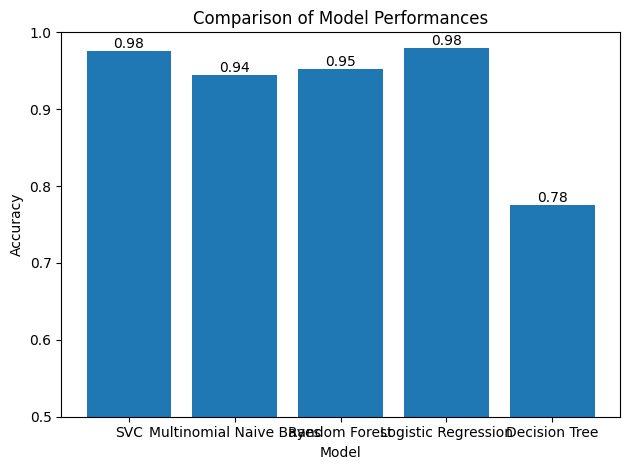

In [ ]:
# Define the models and their corresponding accuracies
models = ['SVC', 'Multinomial Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_svc_tfidf, accuracy_nb_tfidf, accuracy_rf_tfidf, accuracy_lr_tfidf, accuracy_dt_tfidf]

# Plot the accuracies
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performances')
plt.ylim([0.5, 1])  # Set the y-axis limit from 0 to 1
# Aggiungere i valori sopra ogni barra
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()

##**Word embedding CBOW**

Transitioning from our prior analyses grounded in TF-IDF representations, our attention now shifts towards the exploration of Word2Vec embeddings.
Word embeddings are a type of representation of words in a vector space. Word embeddings represent words as vectors in a high-dimensional space, where words with similar meanings are clustered together allowing to capture the semantic meaning of words.
In this project we focus on the implementation of word2vec, a neural network model that learns to predict the context of a word based on its surrounding words.
We will employ the Word2Vec model for document representation in our classification task. Building upon the observation that the SVC classifier demonstrated superior performance in previous sections, we will exclusively utilize this classifier. Our exploration of Word2Vec involves three distinct approaches:

* Pre-trained Word Embeddings
* Continuous Bag of Words (CBOW) Architecture
* Skip-Gram Architecture



In this section, we trained two Word2Vec models: one employing the Continuous Bag of Words (CBOW) approach.

This is the input of our first model with the CBOW:

In [ ]:
model_CBOW = Word2Vec(sentences=X_train.apply(preprocess_text_nltk).to_list(), vector_size=50, window=5, min_count=1, workers=4)

With the CBOW architecture we have created a model which represents each word in the vocabulary as a vector of 50 dimensions. This choice considers the trade-off between model complexity and dataset size.

Now, we want to use these vectors to represent the words of our documents in order to obtain vectors of the same length. \
For this reason the `sent_vec` function is created: by calculating the average Word2Vec embedding for the words in a document, this function generates a uniform, fixed-size representation for documents, making them suitable for classification algorithms that expect consistent input dimensions:

1. `vector_size = model_CBOW.vector_size`: Retrieves the dimensionality of the word vectors in the loaded Word2Vec model (`wv`).
2.	`wv_res = np.zeros(vector_size)`: Initializes a numpy array of zeros with a size equal to the dimensionality of the word vectors. This array, `wv_res`, will be used to accumulate the word vectors.
3.	`ctr = 1`: Initializes a counter variable to keep track of the number of words for which a valid word vector is found. It starts at 1 to avoid division by zero.
4.	The function then iterates through each word (`w`) in the input sentence (`sent`):
o	if `w` in `wv`: Checks if the word `w `has a corresponding word vector in the loaded Word2Vec model (`wv`).
o	If the word vector exists, increments the counter (`ctr`) and adds the word vector to `wv_res`.
5.	After processing all words in the sentence, the function calculates the average word vector by dividing the accumulated word vector (`wv_res`) by the total number of valid words (`ctr`).
6.	The resulting average word vector (`wv_res`) is then returned.

In [ ]:
def sent_vec(sent):
    vector_size = model_CBOW.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in model_CBOW.wv:
            ctr += 1
            wv_res += model_CBOW.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
ds['vec2word'] = ds['processed_text'].apply(sent_vec)

In [ ]:
x_train_cbow, x_test_cbow = X_train.apply(preprocess_text_nltk).apply(sent_vec).to_list(), X_test.apply(preprocess_text_nltk).apply(sent_vec).to_list()

###SVM hyperparameter optimization

In [ ]:
# Define the SVC classifier
classifier_svc_cbow = SVC()

# Define the kernel functions to compare
parameters_svc_cbow = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform grid search and cross-validation
grid_search_svc_cbow = GridSearchCV(classifier_svc_cbow, parameters_svc_cbow, cv=5)
grid_search_svc_cbow.fit(x_train_cbow, y_train)

#Best model
classifier_svc_cbow.kernel = grid_search_svc_cbow.best_params_['kernel']
accuracy_cv_svc_cbow = grid_search_svc_cbow.best_score_

#Assegno il kernel selezionato
classifier_svc_cbow.kernel = grid_search_svc_cbow.best_params_['kernel']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_svc_cbow = grid_search_svc_cbow.score(x_test_cbow,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("SVC - Best Kernel:", classifier_svc_cbow.kernel)
print("SVC - Cross-validated Accuracy:", accuracy_cv_svc_cbow)
print("SVC - Test accuracy:", accuracy_svc_cbow)
result_cv_svc_cbow = pd.DataFrame(grid_search_svc_cbow.cv_results_)
print(result_cv_svc_cbow.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

SVC - Best Kernel: linear
SVC - Cross-validated Accuracy: 0.8934522418065359
SVC - Test accuracy: 0.8949044585987261
                  params  mean_test_score  rank_test_score  mean_fit_time
0   {'kernel': 'linear'}         0.893452                1       0.029622
1      {'kernel': 'rbf'}         0.782129                3       0.079945
2     {'kernel': 'poly'}         0.802623                2       0.079090
3  {'kernel': 'sigmoid'}         0.590166                4       0.236474


### Decision Tree Hyperparameter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_dt_cbow = DecisionTreeClassifier()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid_dt_cbow = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"]}

# Perform grid search and cross-validation
grid_search_dt_cbow = GridSearchCV(classifier_dt_cbow, param_grid_dt_cbow, cv=5)
grid_search_dt_cbow.fit(x_train_cbow, y_train)

#Assegno i parametre selezionati
classifier_dt_cbow.max_depth = grid_search_dt_cbow.best_params_['max_depth']
classifier_dt_cbow.min_samples_leaf = grid_search_dt_cbow.best_params_['min_samples_leaf']
classifier_dt_cbow.criterion = grid_search_dt_cbow.best_params_['criterion']

# Evaluate the best model
best_model_dt_cbow = grid_search_dt_cbow.best_estimator_
accuracy_cv_dt_cbow = grid_search_dt_cbow.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_dt_cbow = grid_search_dt_cbow.score(x_test_cbow,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Decision tree - Best Parameters:", grid_search_dt_cbow.best_params_)
print("Decision tree - Cross-validated Accuracy:", accuracy_cv_dt_cbow)
print("Decision tree - Test accuracy:", accuracy_dt_cbow)

Decision tree - Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
Decision tree - Cross-validated Accuracy: 0.8470311842535881
Decision tree - Test accuracy: 0.8535031847133758


### Random Forest hyperparameter optimization

In [ ]:
# Define the Random forest classifier
classifier_rf_cbow = RandomForestClassifier()

# Define the hyperparameter grid for the Random forest classifier
param_grid_rf_cbow = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"], "n_estimators": [10,20,50,100,150]}

# Perform grid search and cross-validation
grid_search_rf_cbow = GridSearchCV(classifier_rf_cbow, param_grid_rf_cbow, cv=5)
grid_search_rf_cbow.fit(x_train_cbow, y_train)

#Assegno gli iperparametri selezionati
classifier_rf_cbow.max_depth = grid_search_rf_cbow.best_params_['max_depth']
classifier_rf_cbow.min_samples_leaf = grid_search_rf_cbow.best_params_['min_samples_leaf']
classifier_rf_cbow.criterion = grid_search_rf_cbow.best_params_['criterion']
classifier_rf_cbow.n_estimators = grid_search_rf_cbow.best_params_['n_estimators']

# Evaluate the best model
accuracy_cv_rf_cbow = grid_search_rf_cbow.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_rf_cbow = grid_search_rf_cbow.score(x_test_cbow,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Random forest - Best Parameters:", grid_search_rf_cbow.best_params_)
print("Random forest - Cross-validated Accuracy:", accuracy_cv_rf_cbow)
print("Random forest - Test accuracy:", accuracy_rf_cbow)

Random forest - Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 150}
Random forest - Cross-validated Accuracy: 0.8948197671700407
Random forest - Test accuracy: 0.8964968152866242


### Logistic regression hyperparameter optimization

In [ ]:
# Define the Logistic Regression classifier
classifier_lr_cbow = LogisticRegression()

# Define the kernel functions to compare
combinations = {1 : [None, "newton-cg"], 2 : ["elasticnet", "saga", 0.5], 3 : ["l1", "saga"], 4 : ["l2", "lbfgs"]}

# Perform grid search and cross-validation
accuracy_cv_lr_cbow = 0
best_parameter_lr_cbow = None

for combination in combinations:
    classifier_lr_cbow.penalty = combinations[combination][0]
    classifier_lr_cbow.solver = combinations[combination][1]
    if classifier_lr_cbow.penalty == "elasticnet":
        classifier_lr_cbow.l1_ratio = combinations[combination][2]
    else:
        classifier_lr_cbow.l1_ratio = None
    scores_lr_cbow = cross_val_score(classifier_lr_cbow, x_train_cbow, y_train, cv=5)
    accuracy = scores_lr_cbow.mean()

    if accuracy > accuracy_cv_lr_cbow:
        accuracy_cv_lr_cbow = accuracy
        best_parameter_lr_cbow = combinations[combination]

#Assegno gli iperparametri selezionati
classifier_lr_cbow.penalty = best_parameter_lr_cbow[0]
classifier_lr_cbow.solver = best_parameter_lr_cbow[1]
if classifier_lr_cbow.penalty == "elasticnet":
    classifier_lr_cbow.l1_ratio = best_parameter_lr_cbow[2]

#Training the model with best hyper-parameter on the entire trainset
classifier_lr_cbow.fit(x_train_cbow, y_train)

#Accuracy calculated on the test set
accuracy_lr_cbow = classifier_lr_cbow.score(x_test_cbow,y_test)

print("Logistic Regression - Best parameters:", best_parameter_lr_cbow)
print("Logistic Regression - Cross-validated Accuracy:", accuracy_cv_lr_cbow)
print("Logistic Regression - Test accuracy:", accuracy_lr_cbow)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Logistic Regression - Best parameters: [None, 'newton-cg']
Logistic Regression - Cross-validated Accuracy: 0.9453574267146664
Logistic Regression - Test accuracy: 0.9331210191082803


###Performance evaluation

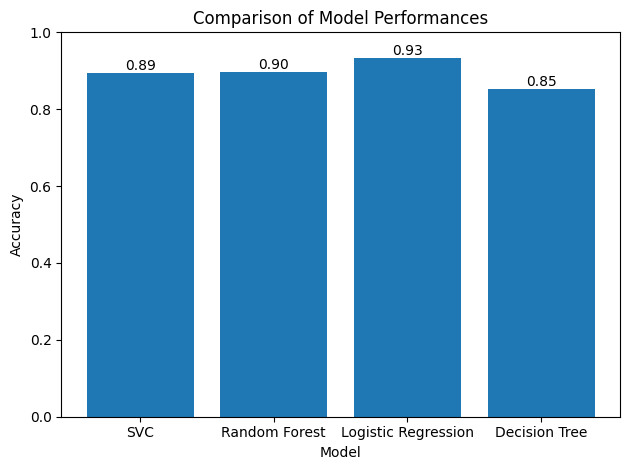

In [ ]:
# Define the models and their corresponding accuracies
models = ['SVC', 'Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_svc_cbow, accuracy_rf_cbow, accuracy_lr_cbow, accuracy_dt_cbow]

# Plot the accuracies
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performances')
plt.ylim([0, 1])  # Set the y-axis limit from 0 to 1
# Aggiungere i valori sopra ogni barra
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()

##**Word embedding skip-gram**

Now, we try the skip-gram approach setting `sg=1`. With the same consideration of above, the skip-gram model represents each word as a 100-dimensional vector:

In [ ]:
model_SG = Word2Vec(sentences=X_train.apply(preprocess_text_nltk).to_list(), vector_size=100, window=5, sg=1, min_count=1)

In [ ]:
def sent_vec(sent):
    vector_size = model_SG.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in model_SG.wv:
            ctr += 1
            wv_res += model_SG.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
X_train_sg, x_test_sg = X_train.apply(preprocess_text_nltk).apply(sent_vec).to_list(), X_test.apply(preprocess_text_nltk).apply(sent_vec).to_list()

### SVM hyperparameter optimization

In [ ]:
# Define the SVC classifier
classifier_svc_sg = SVC()

# Define the kernel functions to compare
parameters_svc_sg = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform grid search and cross-validation
grid_search_svc_sg = GridSearchCV(classifier_svc_sg, parameters_svc_sg, cv=5)
grid_search_svc_sg.fit(X_train_sg, y_train)

#Best model
classifier_svc_sg.kernel = grid_search_svc_sg.best_params_['kernel']
accuracy_cv_svc_sg = grid_search_svc_sg.best_score_

#Assegno il kernel selezionato
classifier_svc_sg.kernel = grid_search_svc_sg.best_params_['kernel']

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_svc_sg = grid_search_svc_sg.score(x_test_sg,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("SVC - Best Kernel:", classifier_svc_sg.kernel)
print("SVC - Cross-validated Accuracy:", accuracy_cv_svc_sg)
print("SVC - Test accuracy:", accuracy_svc_sg)
result_cv_svc_sg = pd.DataFrame(grid_search_svc_sg.cv_results_)
print(result_cv_svc_sg.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

SVC - Best Kernel: linear
SVC - Cross-validated Accuracy: 0.9576604796858199
SVC - Test accuracy: 0.9665605095541401
                  params  mean_test_score  rank_test_score  mean_fit_time
0   {'kernel': 'linear'}         0.957660                1       0.019033
1      {'kernel': 'rbf'}         0.956978                2       0.027608
2     {'kernel': 'poly'}         0.955613                3       0.021702
3  {'kernel': 'sigmoid'}         0.952195                4       0.076480


### Decision Tree Hyperparameter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_dt_sg = DecisionTreeClassifier()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid_dt_sg = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"]}

# Perform grid search and cross-validation
grid_search_dt_sg = GridSearchCV(classifier_dt_sg, param_grid_dt_sg, cv=5)
grid_search_dt_sg.fit(X_train_sg, y_train)

#Assegno i parametre selezionati
classifier_dt_sg.max_depth = grid_search_dt_sg.best_params_['max_depth']
classifier_dt_sg.min_samples_leaf = grid_search_dt_sg.best_params_['min_samples_leaf']
classifier_dt_sg.criterion = grid_search_dt_sg.best_params_['criterion']

# Evaluate the best model
best_model_dt_sg = grid_search_dt_sg.best_estimator_
accuracy_cv_dt_sg = grid_search_dt_sg.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_dt_sg = grid_search_dt_sg.score(x_test_sg,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Decision tree - Best Parameters:", grid_search_dt_sg.best_params_)
print("Decision tree - Cross-validated Accuracy:", accuracy_cv_dt_sg)
print("Decision tree - Test accuracy:", accuracy_dt_sg)
#result_cv_dt_tfidf = pd.DataFrame(grid_search_dt_tfidf.cv_results_)
#print(result_cv_dt_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Decision tree - Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}
Decision tree - Cross-validated Accuracy: 0.9378512319416522
Decision tree - Test accuracy: 0.9187898089171974


### Random Forest hyperparameter optimization

In [ ]:
# Define the Random forest classifier
classifier_rf_sg = RandomForestClassifier()

# Define the hyperparameter grid for the Random forest classifier
param_grid_rf_sg = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"], "n_estimators": [10,20,50,100,150]}

# Perform grid search and cross-validation
grid_search_rf_sg = GridSearchCV(classifier_rf_sg, param_grid_rf_sg, cv=5)
grid_search_rf_sg.fit(X_train_sg, y_train)

#Assegno gli iperparametri selezionati
classifier_rf_sg.max_depth = grid_search_rf_sg.best_params_['max_depth']
classifier_rf_sg.min_samples_leaf = grid_search_rf_sg.best_params_['min_samples_leaf']
classifier_rf_sg.criterion = grid_search_rf_sg.best_params_['criterion']
classifier_rf_sg.n_estimators = grid_search_rf_sg.best_params_['n_estimators']

# Evaluate the best model
accuracy_cv_rf_sg = grid_search_rf_sg.best_score_

#Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_rf_sg = grid_search_rf_sg.score(x_test_sg,y_test)

#classifier_svc.fit(X_train_vectorized, y_train)
print("Random forest - Best Parameters:", grid_search_rf_sg.best_params_)
print("Random forest - Cross-validated Accuracy:", accuracy_cv_rf_sg)
print("Random forest - Test accuracy:", accuracy_rf_sg)
#result_cv_rf_tfidf = pd.DataFrame(grid_search_rf_tfidf.cv_results_)
#print(result_cv_rf_tfidf.loc[:,["params","mean_test_score","rank_test_score","mean_fit_time"]])

Random forest - Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 50}
Random forest - Cross-validated Accuracy: 0.9617583804759455
Random forest - Test accuracy: 0.9538216560509554


### Logistic regression hyperparameter optimization

In [ ]:
# Define the Logistic Regression classifier
classifier_lr_sg = LogisticRegression()

# Define the kernel functions to compare
combinations_sg = {1 : [None, "newton-cg"], 2 : ["elasticnet", "saga", 0.5], 3 : ["l1", "saga"], 4 : ["l2", "lbfgs"]}

# Perform grid search and cross-validation
accuracy_cv_lr_sg = 0
best_parameter_lr_sg = None

for combination in combinations:
    classifier_lr_sg.penalty = combinations[combination][0]
    classifier_lr_sg.solver = combinations[combination][1]
    if classifier_lr_sg.penalty == "elasticnet":
        classifier_lr_sg.l1_ratio = combinations[combination][2]
    else:
        classifier_lr_sg.l1_ratio = None
    scores_lr_sg = cross_val_score(classifier_lr_sg, X_train_sg, y_train, cv=5)
    accuracy = scores_lr_sg.mean()

    if accuracy > accuracy_cv_lr_sg:
        accuracy_cv_lr_sg = accuracy
        best_parameter_lr_sg = combinations[combination]

#Assegno gli iperparametri selezionati
classifier_lr_sg.penalty = best_parameter_lr_sg[0]
classifier_lr_sg.solver = best_parameter_lr_sg[1]
if classifier_lr_sg.penalty == "elasticnet":
    classifier_lr_sg.l1_ratio = best_parameter_lr_sg[2]

#Training the model with best hyper-parameter on the entire trainset
classifier_lr_sg.fit(X_train_sg, y_train)

#Accuracy calculated on the test set
accuracy_lr_sg = classifier_lr_sg.score(x_test_sg,y_test)

print("Logistic Regression - Best parameters:", best_parameter_lr_sg)
print("Logistic Regression - Cross-validated Accuracy:", accuracy_cv_lr_sg)
print("Logistic Regression - Test accuracy:", accuracy_lr_sg)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Best parameters: ['l1', 'saga']
Logistic Regression - Cross-validated Accuracy: 0.9576651549862077
Logistic Regression - Test accuracy: 0.9617834394904459


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


###Performance evaluation

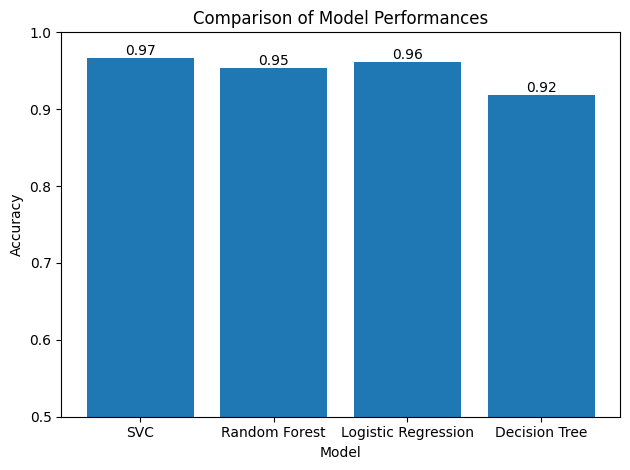

In [ ]:
# Define the models and their corresponding accuracies
models = ['SVC', 'Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_svc_sg, accuracy_rf_sg, accuracy_lr_sg, accuracy_dt_sg]

# Plot the accuracies
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performances')
plt.ylim([0.5, 1])  # Set the y-axis limit from 0 to 1
# Aggiungere i valori sopra ogni barra
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()

##**Pre-trained word2vec**

In [ ]:
#wv = api.load('word2vec-google-news-300')
#wv.save(directory + 'vectors_ggnews300')

In [ ]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load(directory + 'vectors_ggnews300')

In [ ]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
x_train_pt, x_test_pt = X_train.apply(preprocess_text_nltk).apply(sent_vec).to_list(), X_test.apply(preprocess_text_nltk).apply(sent_vec).to_list()

### SVM hyperparameter optimization

In [ ]:
# Define the SVC classifier
classifier_svc_pt = SVC()

# Define the kernel functions to compare
parameters_svc_pt = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Perform grid search and cross-validation
grid_search_svc_pt = GridSearchCV(classifier_svc_pt, parameters_svc_pt, cv=5)
grid_search_svc_pt.fit(x_train_pt, y_train)

# Best model
classifier_svc_pt.kernel = grid_search_svc_pt.best_params_['kernel']
accuracy_cv_svc_pt = grid_search_svc_pt.best_score_

# Assign the selected kernel
classifier_svc_pt.kernel = grid_search_svc_pt.best_params_['kernel']

# Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_svc_pt = grid_search_svc_pt.score(x_test_pt, y_test)

# classifier_svc.fit(X_train_vectorized, y_train)
print("SVC - Best Kernel:", classifier_svc_pt.kernel)
print("SVC - Cross-validated Accuracy:", accuracy_cv_svc_pt)
print("SVC - Test accuracy:", accuracy_svc_pt)
result_cv_svc_pt = pd.DataFrame(grid_search_svc_pt.cv_results_)
print(result_cv_svc_pt.loc[:, ["params", "mean_test_score", "rank_test_score", "mean_fit_time"]])


SVC - Best Kernel: poly
SVC - Cross-validated Accuracy: 0.9644887559025668
SVC - Test accuracy: 0.9681528662420382
                  params  mean_test_score  rank_test_score  mean_fit_time
0   {'kernel': 'linear'}         0.957663                3       0.065541
1      {'kernel': 'rbf'}         0.963124                2       0.071319
2     {'kernel': 'poly'}         0.964489                1       0.060963
3  {'kernel': 'sigmoid'}         0.952200                4       0.104186


### Decision Tree Hyperparameter optimization

In [ ]:
# Define the Naive Bayes classifier
classifier_dt_pt = DecisionTreeClassifier()

# Define the hyperparameter grid for the Naive Bayes classifier
param_grid_dt_pt = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"]}

# Perform grid search and cross-validation
grid_search_dt_pt = GridSearchCV(classifier_dt_pt, param_grid_dt_pt, cv=5)
grid_search_dt_pt.fit(x_train_pt, y_train)

# Assign the selected parameters
classifier_dt_pt.max_depth = grid_search_dt_pt.best_params_['max_depth']
classifier_dt_pt.min_samples_leaf = grid_search_dt_pt.best_params_['min_samples_leaf']
classifier_dt_pt.criterion = grid_search_dt_pt.best_params_['criterion']

# Evaluate the best model
best_model_dt_pt = grid_search_dt_pt.best_estimator_
accuracy_cv_dt_pt = grid_search_dt_pt.best_score_

# Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_dt_pt = grid_search_dt_pt.score(x_test_pt, y_test)

# classifier_svc.fit(X_train_vectorized, y_train)
print("Decision tree - Best Parameters:", grid_search_dt_pt.best_params_)
print("Decision tree - Cross-validated Accuracy:", accuracy_cv_dt_pt)
print("Decision tree - Test accuracy:", accuracy_dt_pt)


Decision tree - Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5}
Decision tree - Cross-validated Accuracy: 0.8258170087428118
Decision tree - Test accuracy: 0.8232484076433121


### Random Forest hyperparameter optimization

In [ ]:
# Define the Random forest classifier
classifier_rf_pt = RandomForestClassifier()

# Define the hyperparameter grid for the Random forest classifier
param_grid_rf_pt = {'max_depth': [2, 5, 10, 15, 20], "min_samples_leaf": [5,10,15,20], "criterion": ["gini","entropy"], "n_estimators": [10,20,50,100,150]}

# Perform grid search and cross-validation
grid_search_rf_pt = GridSearchCV(classifier_rf_pt, param_grid_rf_pt, cv=5)
grid_search_rf_pt.fit(x_train_pt, y_train)

# Assign the selected hyperparameters
classifier_rf_pt.max_depth = grid_search_rf_pt.best_params_['max_depth']
classifier_rf_pt.min_samples_leaf = grid_search_rf_pt.best_params_['min_samples_leaf']
classifier_rf_pt.criterion = grid_search_rf_pt.best_params_['criterion']
classifier_rf_pt.n_estimators = grid_search_rf_pt.best_params_['n_estimators']

# Evaluate the best model
accuracy_cv_rf_pt = grid_search_rf_pt.best_score_

# Accuracy calculated on the test set using the model trained on the entire training set with optimized hyperparameters.
accuracy_rf_pt = grid_search_rf_pt.score(x_test_pt, y_test)

# classifier_svc.fit(X_train_vectorized, y_train)
print("Random forest - Best Parameters:", grid_search_rf_pt.best_params_)
print("Random forest - Cross-validated Accuracy:", accuracy_cv_rf_pt)
print("Random forest - Test accuracy:", accuracy_rf_pt)

Random forest - Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 150}
Random forest - Cross-validated Accuracy: 0.9453667773154425
Random forest - Test accuracy: 0.9410828025477707


### Logistic regression hyperparameter optimization

In [ ]:
# Define the Logistic Regression classifier
classifier_lr_pt = LogisticRegression()

# Define the kernel functions to compare
combinations = {1 : [None, "newton-cg"], 2 : ["elasticnet", "saga", 0.5], 3 : ["l1", "saga"], 4 : ["l2", "lbfgs"]}

# Perform grid search and cross-validation
accuracy_cv_lr_pt = 0
best_parameter_lr_pt = None

for combination in combinations:
    classifier_lr_pt.penalty = combinations[combination][0]
    classifier_lr_pt.solver = combinations[combination][1]
    if classifier_lr_pt.penalty == "elasticnet":
        classifier_lr_pt.l1_ratio = combinations[combination][2]
    else:
        classifier_lr_pt.l1_ratio = None
    scores_lr_pt = cross_val_score(classifier_lr_pt, x_train_pt, y_train, cv=5)
    accuracy = scores_lr_pt.mean()

    if accuracy > accuracy_cv_lr_pt:
        accuracy_cv_lr_pt = accuracy
        best_parameter_lr_pt = combinations[combination]

# Assign the selected hyperparameters
classifier_lr_pt.penalty = best_parameter_lr_pt[0]
classifier_lr_pt.solver = best_parameter_lr_pt[1]
if classifier_lr_pt.penalty == "elasticnet":
    classifier_lr_pt.l1_ratio = best_parameter_lr_pt[2]

# Training the model with best hyper-parameter on the entire trainset
classifier_lr_pt.fit(x_train_pt, y_train)

# Accuracy calculated on the test set
accuracy_lr_pt = classifier_lr_pt.score(x_test_pt, y_test)

print("Logistic Regression - Best parameters:", best_parameter_lr_pt)
print("Logistic Regression - Cross-validated Accuracy:", accuracy_cv_lr_pt)
print("Logistic Regression - Test accuracy:", accuracy_lr_pt)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Best parameters: [None, 'newton-cg']
Logistic Regression - Cross-validated Accuracy: 0.9638014867455234
Logistic Regression - Test accuracy: 0.9665605095541401


###Performance evaluation

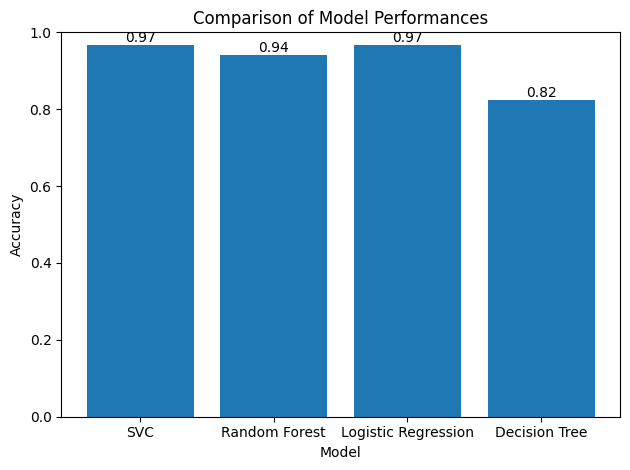

In [ ]:
# Define the models and their corresponding accuracies
models = ['SVC', 'Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_svc_pt, accuracy_rf_pt, accuracy_lr_pt, accuracy_dt_pt]

# Plot the accuracies
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Performances')
plt.ylim([0, 1])  # Set the y-axis limit from 0 to 1
# Aggiungere i valori sopra ogni barra
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()

###**Evaluation**

In this section, we will evaluate the text representation times between TF-IDF and those resulting from pretrained word embeddings. Finally, we calculate the prediction times for both in relation to the chosen ML models.

In [ ]:
start_tfidf = time.time()
tfidf_train.transform(X_test)
end_tfidf = time.time()

start_train_tfidf = time.time()
classifier_lr.fit(X_train_vectorized, y_train)
end_train_tfidf = time.time()

start_tfidf_prediction = time.time()
classifier_lr.score(x_test_vectorized,y_test)
end_tfidf_prediction = time.time()

# Output results
print("TF-IDF - Representation Time:", end_tfidf - start_tfidf, "seconds")
print("TF-IDF - Training Time:", end_train_tfidf - start_train_tfidf, "seconds")
print("TF-IDF - Classification Time:", end_tfidf_prediction - start_tfidf_prediction, "seconds")
print("TF-IDF - Total Time:", end_tfidf_prediction - start_tfidf, "seconds")

TF-IDF - Representation Time: 0.3118021488189697 seconds
TF-IDF - Training Time: 5.57202672958374 seconds
TF-IDF - Classification Time: 1.006748914718628 seconds
TF-IDF - Total Time: 6.890728235244751 seconds


In [ ]:
final_classifier_svc_pt = SVC(kernel=grid_search_svc_pt.best_params_['kernel'])
xx = X_test.apply(preprocess_text_nltk)
start_pt = time.time()
xx.apply(sent_vec).to_list()
end_pt = time.time()


start_train_pt = time.time()
final_classifier_svc_pt.fit(x_train_pt, y_train)
end_train_pt = time.time()

start_pt_prediction = time.time()
accuracy_svc_pt = grid_search_svc_pt.score(x_test_pt, y_test)
end_pt_prediction = time.time()

# Output results
print("Pretrained - Representation Time:", end_pt - start_pt, "seconds")
print("Pretrained - Training Time:", end_train_pt - start_train_pt, "seconds")
print("Pretrainded - Classification Time:", end_pt_prediction - start_pt_prediction, "seconds")
print("Pretrained - Total Time:", end_pt_prediction - start_pt, "seconds")

Pretrained - Representation Time: 0.4191451072692871 seconds
Pretrained - Training Time: 0.10066819190979004 seconds
Pretrainded - Classification Time: 0.03460550308227539 seconds
Pretrained - Total Time: 0.5544962882995605 seconds


#**Text summarization**

In [ ]:
! pip install rouge_score
! pip install sumy

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a7e4aa00eb1fba56baef0962dbd879c2527a2a469050d1863f7096e3c53446e4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.4 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=50e231f487741ed9cd218fc78374c7d90946f1716bb58070400dec7e89382a72
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2af704d531a99dd775a9f82c84cbb1adb19d6744bdd9abac4307a4673ddd9

import of libraries required for text summarization techniques

In [ ]:
import numpy as np
# Extractive with LSA
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

# Abstractive with BART
from transformers import pipeline


# Evaluation with Rouge
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## EXTRACTIVE WITH LSA-SUMY

In [ ]:
Definition of the function that effectuates the text summarization technique with the extractive approach

In [ ]:
def extractive_summary(text, num_sentences=5):
  parser = PlaintextParser.from_string(text, Tokenizer("english"))
  summarizer = LsaSummarizer()
  summmary = summarizer(parser.document, num_sentences)
  return " ".join([str(sentence) for sentence in summmary])

## EVALUATION WITH ROUGE

In [ ]:
function thet compute the rogue metrics

In [ ]:
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }

In [ ]:
rouge_scores = []
for index, row in ds.iterrows():
        content = row['content']
        reference_summary = row['title']
        summary_extractive = extractive_summary(content)
        scores_extractive = calculate_rouge(reference_summary, summary_extractive)

        rouge_scores.append({
            "index": index,
            "extractive_rouge1": scores_extractive["rouge1"],
            "extractive_rouge2": scores_extractive["rouge2"],
            "extractive_rougeL": scores_extractive["rougeL"]
        })

    # Crea un DataFrame con i risultati
rouge_df = pd.DataFrame(rouge_scores)
print(rouge_df.head())


   index  extractive_rouge1  extractive_rouge2  extractive_rougeL
0      0           0.068182           0.023256           0.068182
1      1           0.046154           0.000000           0.030769
2      2           0.081633           0.000000           0.061224
3      3           0.118812           0.080808           0.118812
4      4           0.059406           0.000000           0.019802


### EXTRACTIVE ROUGE-1

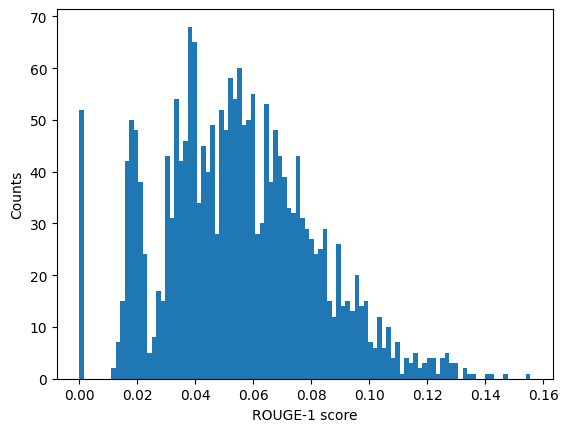

In [ ]:
plt.hist(rouge_df["extractive_rouge1"], bins=100)
plt.xlabel("ROUGE-1 score")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df["extractive_rouge1"])



0.054774049935016826

In [ ]:
np.std(rouge_df["extractive_rouge1"])


0.02608366758053337

### EXTRACTIVE ROUGE-2

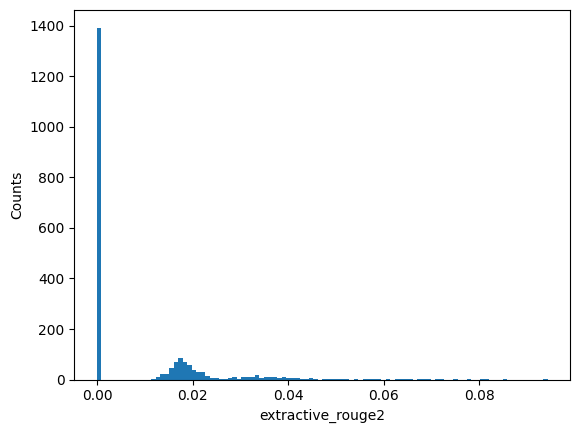

In [ ]:
plt.hist(rouge_df["extractive_rouge2"], bins=100)
plt.xlabel("extractive_rouge2")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df["extractive_rouge2"])

0.008203124372212567

In [ ]:
np.std(rouge_df["extractive_rouge2"])

0.013574742835091904

### EXTRACTIVE ROUGE-L

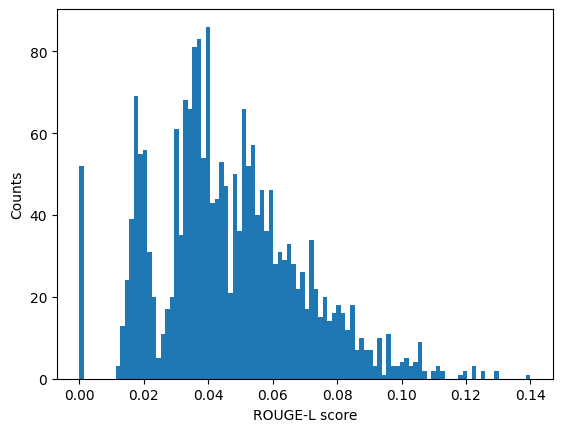

In [ ]:
plt.hist(rouge_df["extractive_rougeL"], bins=100)
plt.xlabel("ROUGE-L score")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df["extractive_rougeL"])

0.046437290899940316

In [ ]:
np.std(rouge_df["extractive_rougeL"])

0.02241325550135594

## ABSTRACTIVE WITH BART


In [ ]:
!pip install txtai
from txtai.pipeline import Summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 2.2.2 which is incompatible.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, bu

In [ ]:
Definition of the part of the code  that effectuates the text summarization technique with the abstractive approach

In [ ]:
summary = Summary('facebook/bart-large-cnn')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
ds.reset_index(drop=True, inplace=True)  # Reset the index to consecutive integers

ds['summary'] = ''

for i in range(len(ds)):  # Iterate over all rows in the DataFrame
    ds.loc[i, 'summary'] = summary(ds.loc[i, 'content'])




calculation of rogue metrics

In [ ]:
rouge_scores_2 = []
for index, row in ds.iterrows():
        content = row['summary']
        reference_summary = row['title']
        scores_abstractive = calculate_rouge(reference_summary, content)

        rouge_scores_2.append({
            "index": index,
            "abstractive_rouge1": scores_abstractive["rouge1"],
            "abstractive_rogue2": scores_abstractive["rouge2"],
            "abstractive_rougeL": scores_abstractive["rougeL"]
        })

    # Crea un DataFrame con i risultati
rouge_df_2 = pd.DataFrame(rouge_scores_2)
print(rouge_df_2.head())

   index  abstractive_rouge1  abstractive_rogue2  abstractive_rougeL
0      0            0.041667            0.000000            0.041667
1      1            0.056338            0.000000            0.056338
2      2            0.156863            0.000000            0.078431
3      3            0.188679            0.078431            0.188679
4      4            0.068966            0.000000            0.034483


ABSTRACTIVE ROUGE-1

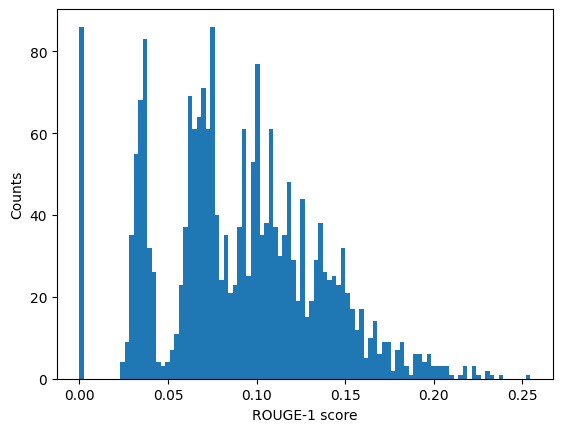

In [ ]:
plt.hist(rouge_df_2["abstractive_rouge1"], bins=100)
plt.xlabel("ROUGE-1 score")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df_2["abstractive_rouge1"])


0.09001299980174325

In [ ]:
np.std(rouge_df_2["abstractive_rouge1"])


0.044846424655650724

## ABSTRACTIVE ROGUE 2

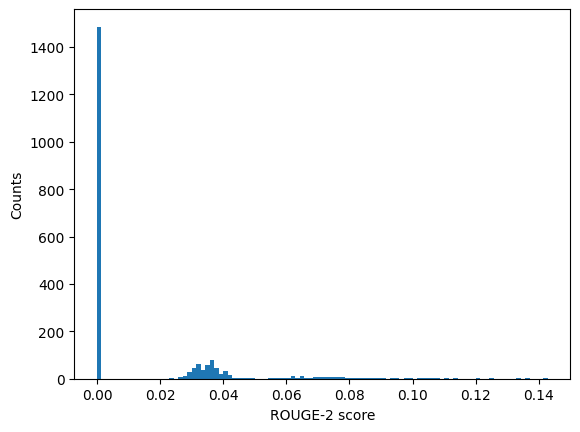

In [ ]:
plt.hist(rouge_df_2["abstractive_rogue2"], bins=100)
plt.xlabel("ROUGE-2 score")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df_2["abstractive_rogue2"])


0.013200062530637163

In [ ]:
np.std(rouge_df_2["abstractive_rogue2"])


0.023490582347602464

## ABSTRACTIVE ROGUE L

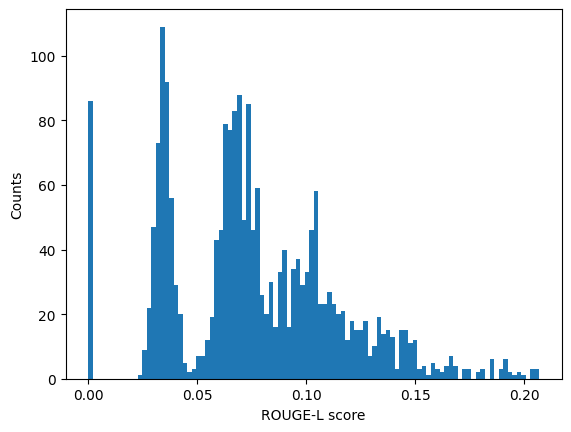

In [ ]:
plt.hist(rouge_df_2["abstractive_rougeL"], bins=100)
plt.xlabel("ROUGE-L score")
plt.ylabel("Counts")
plt.show()

In [ ]:
np.mean(rouge_df_2["abstractive_rougeL"])


0.07600586081115429

In [ ]:
np.std(rouge_df_2["abstractive_rougeL"])


0.038912711624367956